In [24]:
import json
%reload_ext autoreload

In [25]:
%autoreload 2

In [3]:
import re
import time

import pandas as pd
import numpy as np
import nltk
import warnings
import pickle
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split

In [4]:
from analyzer import data_cleaner
from analyzer.analyzer import TfidfDataTransformer

In [3]:
df_train = pd.read_csv('data/train.csv')
df_t = df_train.copy()

In [4]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
df_train['clean_tweet'] = np.vectorize(data_cleaner.clean_mentions)(df_train['tweet'])
df_train['clean_tweet'] = df_train['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


df_train.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional and selfish drags hi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit can use cause they don...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with all the time
4,5,0,factsguide: society now #motivation,factsguide society now #motivation


In [6]:


tr= TfidfDataTransformer()

df_train['clean_tweet'] = tr.stemming(df_train['clean_tweet'])
display(df_train.head())
#df_train['clean_tweet'].to_csv('models/model_data.csv', sep=',')
tr.vectorizer_fit(df_train['clean_tweet'])
df_tfidf = tr.transform(df_train['clean_tweet'])
pickle.dump(tr.vectorizer, open('models/vectorizer.sav', 'wb'))
x_train, x_valid, y_train, y_valid = train_test_split(df_tfidf, df_train['label'],test_size=0.3,random_state=42)

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunct and selfish drag hi kid i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thank for #lyft credit can use caus they don o...
2,3,0,bihday your majesty,bihday your majesti
3,4,0,#model i love u take with u all the time in ...,#model love take with all the time
4,5,0,factsguide: society now #motivation,factsguid societi now #motiv


# Models and balancing

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score




model = LogisticRegression(random_state=0,solver='lbfgs')
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict_proba(x_valid)
predictions

In [ ]:
prediction_int = predictions[:,1]>=0.3
prediction_int = prediction_int.astype(np.int)
log_tfidf = f1_score(y_valid, prediction_int)

log_tfidf

In [ ]:
pickle.dump(model, open('../models/model.sav', 'wb'))
 

In [ ]:
test_data = tr.transform(['This thing is pretty shit', 'I like this pretty much, it is super', 'ugly bad ugly'])
model.predict_proba(test_data)


In [ ]:
from imblearn.under_sampling import TomekLinks,RandomUnderSampler, CondensedNearestNeighbour,EditedNearestNeighbours
#balancing

tl = RandomUnderSampler(sampling_strategy='not minority',random_state=1337) # default - will remove the sample from the majority class
#tl = TomekLinks(sampling_strategy='not minority',n_jobs = -1)
x_train_res, y_train_res = tl.fit_resample(x_train, y_train)
model2 = LogisticRegression(random_state=1337,solver='lbfgs')

model2.fit(x_train_res, y_train_res)


In [ ]:
pickle.dump(model, open('../models/model2.sav', 'wb'))

In [ ]:
predictions = model2.predict_proba(x_valid)
prediction_int = predictions[:,1]>=0.3
prediction_int = prediction_int.astype(np.int32)
log_tfidf = f1_score(y_valid, prediction_int)


In [ ]:
test_data = tr.transform(["it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia ", 'This thing is pretty shit', 'I like this pretty much, it is super', 'ugly bad ugly'])
model2.predict_proba(test_data)

In [ ]:
def analyze_data(model, data_path, data_transformer, data_balancer=None, save_model=True, save_vectorizer=True, verbose=True):
    data_name = data_path.split('/')[-1]
    name = f"{data_name}-{model.__repr__()}"
    if data_balancer is not None:
        name += '-balanced'
    if verbose:
        print(f'Analyzing {name}', end='')
    # Load data
    df_train = pd.read_csv(data_path)
    # Clean data
    df_train['clean_tweet'] = np.vectorize(data_cleaner.clean_mentions)(df_train['tweet'])
    df_train['clean_tweet'] = df_train['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
    df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    # Transform data
    df_train['clean_tweet'] = data_transformer.stemming(df_train['clean_tweet'])
    data_transformer.vectorizer_fit(df_train['clean_tweet'])
    df_tfidf = data_transformer.transform(df_train['clean_tweet'])
    if save_vectorizer:
        pickle.dump(data_transformer.vectorizer, open(f'../models/{data_name}-{data_transformer.vectorizer.__repr__()}.sav', 'wb'))
    x_train, x_valid, y_train, y_valid = train_test_split(df_tfidf, df_train['label'],test_size=0.3,random_state=1337)
    # Balance data
    if data_balancer is not None:
        x_train, y_train = data_balancer.fit_resample(x_train, y_train)
    # Fit model (HYPERPARAMS???)
    model.fit(x_train, y_train)
    if save_model:
        pickle.dump(model, open(f'../models/{name}.sav', 'wb'))
    # Predict
    if isinstance(model, (LogisticRegression, GaussianNB)):
        predictions = model.predict_proba(x_valid)
        prediction_int = predictions[:,1]>=0.3
        prediction_int = prediction_int.astype(np.int32)
    else:
        predictions = model.predict(x_valid)
        prediction_int = predictions[:]>=0.3
        prediction_int = prediction_int.astype(np.int32)
    # Evaluate
    metrics = {
        'f1_score': f1_score(y_valid, prediction_int)
    }
    #
    if verbose:
        print(f' ->> Done')
    return name, model, data_transformer ,predictions, metrics

In [ ]:
from sklearn.linear_model import LogisticRegression
from data_transformation import TfidfDataTransformer
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks,RandomUnderSampler


name, model, tr, pred, metrics = analyze_data(model=LogisticRegression(random_state=0,solver='lbfgs'), data_path='data/train.csv', data_transformer=TfidfDataTransformer(), data_balancer=RandomUnderSampler(sampling_strategy='not minority',random_state=1337))




In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
test_data = tr.transform(["it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia ", 'This thing is pretty shit', 'life', 'ugly bad ugly'])

for m in [LogisticRegression(random_state=0,solver='lbfgs'), GaussianNB(), DecisionTreeRegressor()]:
    name, model, tr, pred, metrics = analyze_data(model=m, data_path='data/train.csv', data_transformer=TfidfDataTransformer(), data_balancer=RandomUnderSampler(sampling_strategy='not minority',random_state=1337))
    print(name)
    print(model.predict_proba(test_data))
    print(f'f1: {metrics["f1_score"]}')

In [ ]:
# Testing
name, model, tr, pred, metrics = analyze_data(model=DecisionTreeRegressor(), data_path='data/train.csv', data_transformer=TfidfDataTransformer(), data_balancer=RandomUnderSampler(sampling_strategy='not minority',random_state=1337))
print(name)
print(model.predict(test_data))
print(f'f1: {metrics["f1_score"]}')

# Testing


In [38]:
def emoji_from_score(score):
    return '😀' if score > 0.85 else '😐' if score > 0.75 else '☹'

def index_dates(data, dates):
    date_time = pd.to_datetime(dates)
    df = pd.DataFrame()
    df['value'] = data
    df = df.set_index(date_time)
    return df




In [42]:
from analyzer.analyzer import Analyzer
import matplotlib.pyplot as plt


test_data = ["it's unbelievable that in the 21st century we'd need something like this. again. #neverump  #xenophobia ", 'This thing is pretty shit', 'life', 'ugly bad ugly']

date_time = ["2021-01-01", "2021-01-02", "2021-01-03", "2021-01-04"]

analyzer = Analyzer('models', 'model.sav', 'vectorizer.sav')
results = analyzer.get_sentiment_analysis(test_data)
results = pd.Series(results).apply(lambda x: (2*x)-1)
results = index_dates(results, date_time)



In [5]:
from datetime import datetime
from collections import namedtuple



def parse_args(text:str):
    date_range = namedtuple("DateRange", ["date_from", "date_to"])
    try:
        split = text.split(' ')
        if len(split) == 0:
            return date_range(None, None)
        if len(split) == 1:
            datetime_from = datetime.strptime(split[0], '%d/%m/%Y')
            return date_range(datetime_from, datetime.today())
        else:
            datetime_from = datetime.strptime(split[0], '%d/%m/%Y')
            datetime_to = datetime.strptime(split[1], '%d/%m/%Y')
            delta = datetime_to - datetime_from
            if delta.days < 0:
                return date_range(datetime_to, datetime_from)
            return date_range(datetime_from, datetime_to)
    except Exception:
        print('Bad format of args.')
        return date_range(None, None)


In [13]:
print(parse_args('25/12/2021'))
print(parse_args('asddas'))
print(parse_args('28/12/2021 27/12/2021'))
x1, x2 = parse_args('asd')
print(x1, x2)

DateRange(date_from=datetime.datetime(2021, 12, 25, 0, 0), date_to=datetime.datetime(2023, 3, 12, 11, 39, 45, 521104))
Bad format of args.
DateRange(date_from=None, date_to=None)
DateRange(date_from=datetime.datetime(2021, 12, 27, 0, 0), date_to=datetime.datetime(2021, 12, 28, 0, 0))
Bad format of args.
None None


In [11]:
stamp = int('1512085950')
date = datetime.fromtimestamp(stamp)

print(date)

2017-12-01 00:52:30


In [16]:
x1 is None or x2 is None

True

In [12]:
from pandas import Timestamp
import datetime
d = [0.971066689798491, 0.9683871815276381, 0.9384783159548654, 0.9377674329937882, 0.9377674329937882, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9332603234385841, 0.9699420042095516, 0.9695004774650493, 0.9774511728719356, 0.7525233700052649, 0.9384783159548654, 0.9384783159548654, 0.9695004774650493, 0.9865760354454112, 0.9874318504974866, 0.8812648753366216, 0.8812648753366216, 0.8812648753366216, 0.9865760354454112, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9384783159548654, 0.9914611246210512, 0.9914611246210512, 0.9914611246210512, 0.9687292947500042]
dat= [datetime.datetime(2023, 3, 16, 13, 22, 22), datetime.datetime(2023, 3, 16, 13, 19, 7), datetime.datetime(2023, 3, 15, 20, 11, 43), datetime.datetime(2023, 3, 15, 20, 11, 41), datetime.datetime(2023, 3, 13, 19, 59, 43), datetime.datetime(2023, 3, 13, 19, 59, 58), datetime.datetime(2023, 3, 13, 20, 0, 2), datetime.datetime(2023, 3, 13, 20, 0, 2), datetime.datetime(2023, 3, 13, 20, 0, 3), datetime.datetime(2023, 3, 13, 20, 0, 5), datetime.datetime(2023, 3, 13, 20, 0, 14), datetime.datetime(2023, 3, 13, 21, 15, 35), datetime.datetime(2023, 3, 13, 21, 15, 38), datetime.datetime(2023, 3, 12, 13, 29, 23), datetime.datetime(2023, 3, 12, 13, 29, 16), datetime.datetime(2023, 3, 12, 13, 29, 14), datetime.datetime(2023, 3, 12, 13, 29, 13), datetime.datetime(2023, 3, 12, 12, 38, 5), datetime.datetime(2023, 3, 12, 12, 37, 24), datetime.datetime(2023, 2, 22, 16, 47, 42), datetime.datetime(2023, 2, 22, 16, 46, 56), datetime.datetime(2023, 2, 22, 16, 46, 55), datetime.datetime(2023, 2, 22, 16, 46, 41), datetime.datetime(2023, 2, 22, 15, 52, 23), datetime.datetime(2023, 2, 22, 14, 50, 18), datetime.datetime(2023, 2, 22, 14, 50, 8), datetime.datetime(2023, 2, 22, 14, 50), datetime.datetime(2023, 2, 22, 14, 4, 58), datetime.datetime(2023, 2, 22, 14, 4, 57), datetime.datetime(2023, 2, 22, 14, 4, 56), datetime.datetime(2023, 2, 22, 13, 46, 54), datetime.datetime(2023, 2, 22, 13, 46, 51), datetime.datetime(2023, 2, 17, 10, 42, 11), datetime.datetime(2023, 2, 17, 10, 41, 7), datetime.datetime(2023, 2, 17, 10, 27, 3), datetime.datetime(2023, 2, 17, 10, 26, 34), datetime.datetime(2023, 2, 17, 10, 24, 51), datetime.datetime(2023, 2, 17, 10, 24, 41), datetime.datetime(2023, 2, 17, 10, 22, 54), datetime.datetime(2023, 2, 17, 9, 20, 56)]

In [5]:
import statsmodels.api as sm
from analyzer.time_analyzer import TimeSeriesAnalyzer
import pandas as pd


In [8]:
def extract_trend(data, model='additive', start_date=None):
    data = data.resample('1d')['value'].agg('mean').fillna(0).asfreq('1D')
    # Create a decomposition object with the specified model
    decomposition = sm.tsa.seasonal_decompose(data, model=model)

    # Extract the trend component from the decomposition object
    trend = decomposition.trend

    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        trend = trend.loc[start_date:]

    return trend.dropna()

def index_dates(data, dates):
    date_time = pd.to_datetime(dates)
    df = pd.DataFrame()
    df['value'] = data
    df = df.set_index(date_time)
    return df

In [13]:
x = index_dates(d, dat)

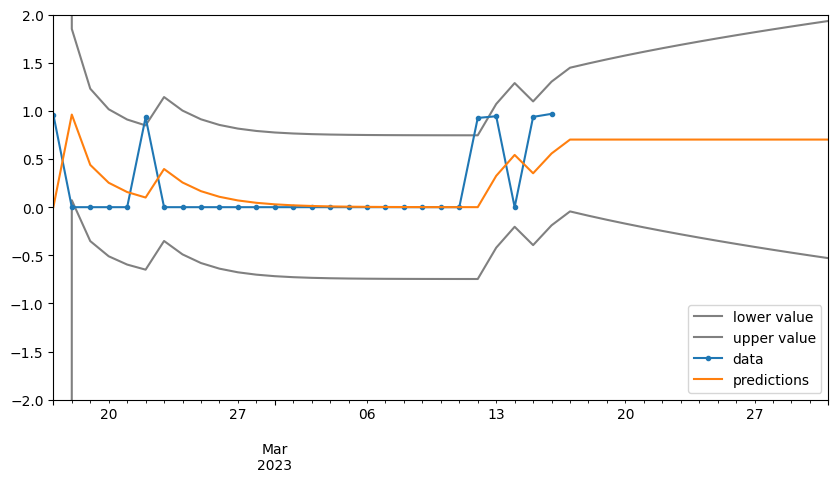

In [73]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def get_prediction(data):
    # Get ARIMA FIT
    stepwise_fit = pm.auto_arima(data, start_p=1, start_q=1,
                                 max_p=5, max_q=5, m=1,
                                 start_P=0, seasonal=False,
                                 d=1,
                                 information_criterion='aic',
                                 stepwise=True)
    model = ARIMA(data, order=stepwise_fit.order, trend='n')
    fmodel = model.fit()
    predictions = fmodel.get_prediction(end='2023-03-31')
    ci = predictions.conf_int()
    fig = ci.plot(color='grey', figsize=(4, 2))
    fmodel.data.orig_endog.plot(label='data', marker='.', fig=fig)
    predictions.predicted_mean.plot(label='predictions', fig=fig)
    plt.ylim(-2, 2)
    plt.legend()
    plt.show()
    return predictions

def plot_function(data, plot_path=None, x_label='Date', y_label='Sentiment value', data2=pd.Series([-1,0,1]), data3=pd.Series([-1,0,1])):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2), width_ratios=[3, 1, 3], sharey=True)
    fig.suptitle('Sentiment analysis', fontsize=14, y=1.1)

    # Plot sentiment values
    data.plot(ax=ax1)
    plt.gcf().autofmt_xdate()
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title("Historical data")

    # Plot trend TODO
    data2.plot(ax=ax2)

    ax2.set_xlabel("Date")
    ax2.set_ylabel("Trend")
    ax2.set_title("Current trend")

    # Plot prediction?
    d3, dd3 = data3
    d3.predicted_mean.plot(label='predictions', ax=ax3)
    ci = d3.conf_int()
    ci.plot(color='grey', ax=ax3)
    dd3.plot(label='data', marker='.', ax=ax3)

    plt.ylim(-1, 1)
    #plt.legend()

    ax3.set_xlabel("Date")
    ax3.set_ylabel("Prediction")
    ax3.set_title("Prediction")
    #ax3.text(4, 0, ''.join(data["value"].apply(lambda x: emoji_from_score(x))), fontsize=20)

    if plot_path is not None:
        plt.savefig(plot_path)
    plt.show()

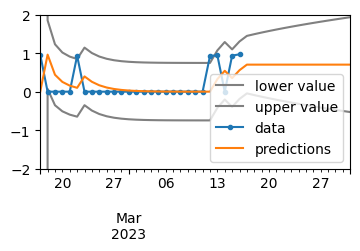

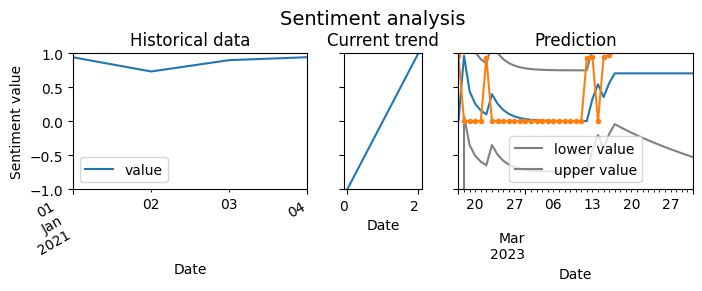

In [74]:
xx = x.resample('1d')['value'].agg('mean').fillna(0).asfreq('1D')
xxx = get_prediction(xx)
plot_function(results,plot_path='out/graphs/foo.png', data3=(xxx, xx))

In [3]:
from googletrans import Translator
from tqdm import tqdm
translator = Translator()
translator.translate('안녕하세요.').text

'hello.'

In [5]:
text = 'to fakt ne lol. prosím, udělejme to jinak, tohle je fakt špatný'
translator.translate('lol ne').text

'lol no'

In [12]:
d = ['to fakt ne' for x in range(1000)]
for dd in tqdm(d):
    translator.translate(dd, src='cs', dest='en').text

100%|██████████| 1000/1000 [01:44<00:00,  9.61it/s]


In [4]:
langs = translator.detect([text, '日本語', 'lol ne', 'le français'])
for lang in langs:
    print(lang.lang, lang.confidence)

cs 1
ja 0.9712484
hr 0.4983079
fr 0.98445046


In [4]:
from helpers.message import Message, Reaction


def try_translate_messages(messages: []) -> []:
    translated_messages = messages.copy()
    langs = [lang.lang for lang in translator.detect([msg.text for msg in messages])]
    for i, lang in enumerate(langs):
        if isinstance(lang, list):
            lang = lang[0]
        if lang != 'en':
            m = messages[i]
            translated = translator.translate(m.text, src=str(lang), dest='en')
            translated_messages[i] = Message(translated.text, m.user, m.timestamp, m.reactions)
    return translated_messages

testing_data = [Message('to fakt ne lol. prosím, udělejme to jinak, tohle je fakt špatný', 'asd', '1231231'),
                Message('are u kidding me', 'asd', '1231231'),
                Message('lol', 'asd', '1231231'),
                Message('zkusíme deploy appky na produkci', 'asd', '1231231', [Reaction(':looool:', 2), Reaction(':smiley face', 2)])]
print(try_translate_messages(testing_data))
x = try_translate_messages(testing_data)

[1970-01-15 07:00:31 >> asd::not really lol. please let's do it differently, this is really bad
 Reactions: [], 1970-01-15 07:00:31 >> asd::are u kidding me
 Reactions: [], 1970-01-15 07:00:31 >> asd::lol
 Reactions: [], 1970-01-15 07:00:31 >> asd::we will try to deploy apps to production
 Reactions: [<helpers.message.Reaction object at 0x00000165FDDB8DF0>, <helpers.message.Reaction object at 0x00000165FDDB9030>]]


In [10]:

from helpers.data_uploader import DataUploader
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import pandas as pd
import os
import json

gauth = GoogleAuth()
# Try to load saved client credentials
credentials = json.loads(os.environ.get('GOOGLE_CREDENTIALS'))
with open('creds.json', 'w') as fp:
    json.dump(credentials, fp)
gauth.LoadCredentialsFile("creds.json")
if gauth.credentials is None:
    # Authenticate if they're not there
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    # Refresh them if expired
    gauth.Refresh()
else:
    # Initialize the saved creds
    gauth.Authorize()
# Save the current credentials to a file
os.environ['GOOGLE_CREDENTIALS'] =

drive = GoogleDrive(gauth)



def save_file(file, remove_after_upload=True):
    gfile = drive.CreateFile({'parents': [{'id': '18104w-v_kKoYurCUrkJ_9_EgE6vjkVee'}]})
    # Read file and set it as the content of this instance.
    gfile.SetContentFile(file)
    try:
        gfile.Upload()
    finally:
        gfile.content.close() # Upload the file.
    if remove_after_upload:
        os.remove(file)

def messages_to_file(messages, file_name='new_file') -> str:
    file_name += f'_{str(pd.Timestamp.now().timestamp())}.csv'
    file_name = file_name.strip()
    path = f'tmp/{file_name}'
    #df = pd.DataFrame([m.__dict__ for m in messages])
    df = pd.DataFrame.from_records([vars(m) for m in messages], exclude=['reactions'])
    # Reaction to column
    df.insert(4, "reactions", [[(r.name, r.count) for r in m.reactions] for m in messages], True)
    df.to_csv(path, sep=';')
    return path

f = messages_to_file(x)
save_file(f)

TypeError: the JSON object must be str, bytes or bytearray, not NoneType

In [2]:
from analyzer.analyzer import Analyzer
from analyzer.time_analyzer import TimeSeriesAnalyzer
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from helpers.message import Message, Reaction
from statistics import mean

analyzer = Analyzer('models', 'old/model_new.sav', 'old/vectorizer.sav')
ts_analyzer = TimeSeriesAnalyzer()

test_messages = [
    Message('what a beautiful day', 'USER1', '1680460430.580102', [Reaction('smiley', 5)]),
    Message('what a beautiful day', 'USER2', '1680374030.580102', [Reaction('face_vomiting', 5)]),
    Message('prosím, udělejme to jinak, tohle je fakt špatný', 'USER2', ' 1680287630.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1680201230.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1680114830.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1680028430.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1679942030.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1679855630.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1679772830.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1679686430.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1679600030.580102', []),
    Message('vůbec nevim, proč sem pořád chodí, příště ho vyhodíme oknem', 'USER3', '1679513630.580102', []),
    Message('bad ugly i hate this', 'USER2', '1679427230.580102', [Reaction('smiley', 5)]),
    Message('bad ugly i hate this', 'USER2', '1679340830.580102', [Reaction('face_vomiting', 5)])
]

test_messages2 = test_messages.copy()
#test_messages2[0].reactions = None
##test_messages2[1].reactions = None
#t#est_messages2[-1].reactions = None
#test_messages2[-2].reactions = None
analyzer2 = Analyzer('models', 'old/model_new.sav', 'old/vectorizer.sav')

In [3]:


sa = analyzer.get_sentiment_analysis(test_messages)
sa2 = analyzer2.get_sentiment_analysis(test_messages2)
# Analyze SA
date_indexed_data = ts_analyzer.index_dates(sa, [m.date.date() for m in test_messages])
date_indexed_data2 = ts_analyzer.index_dates(sa2, [m.date.date() for m in test_messages2])


trend = ts_analyzer.extract_trend(date_indexed_data) #start_date=ts_analyzer.parse_date('last_week')
trend2 = ts_analyzer.extract_trend(date_indexed_data2) #start_date=ts_analyzer.parse_date('last_week')
# Predictions
prediction_data = ts_analyzer.get_predictions(date_indexed_data)
prediction_data2 = ts_analyzer.get_predictions(date_indexed_data2)

# Print Graph
#graph_path = analyzer.get_plot(plot_path='out/graphs/foo.png', trend_data=trend, predictions_data=prediction_data)
#graph_path2 = analyzer2.get_plot(plot_path='out/graphs/foo2.png', trend_data=trend2, predictions_data=prediction_data2)

W:\diploma_thesis\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
W:\diploma_thesis\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


C:\Users\Tomiu\AppData\Local\Temp\ipykernel_18052\691438085.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


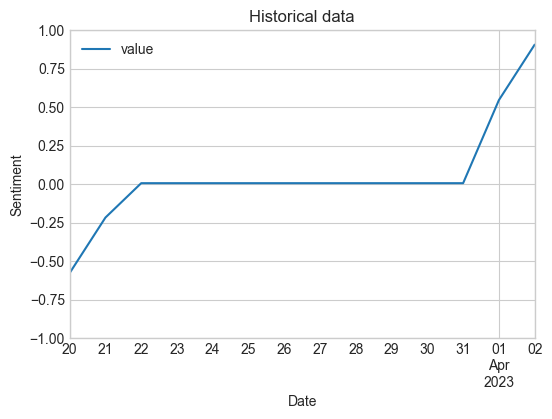

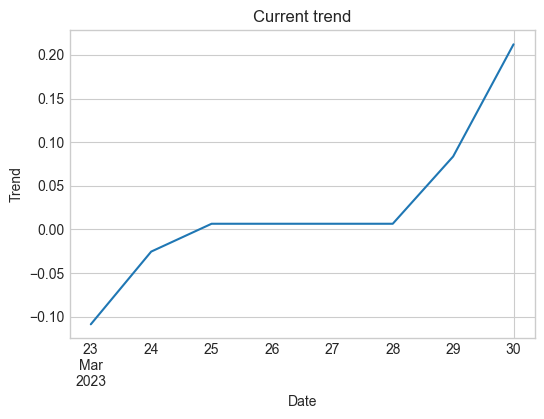

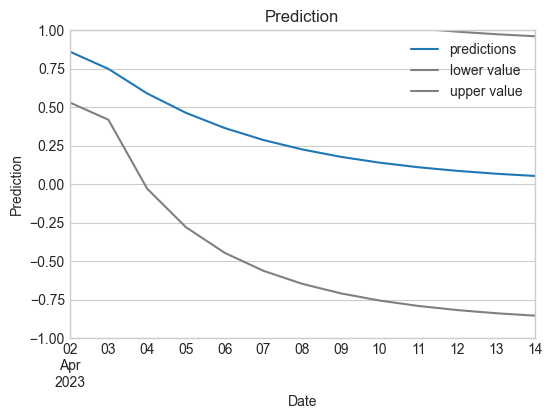

In [4]:
x_label = 'Date'
y_label = 'Sentiment'
trend_data = trend
predictions_data = prediction_data
data = date_indexed_data
from matplotlib.dates import DateFormatter, AutoDateFormatter, AutoDateLocator

figsize = (6, 4)
plt.style.use('seaborn-whitegrid')
# SENTIMENT
fig, ax = plt.subplots(figsize=figsize)
plt.ylim(-1,1)
data.plot(ax=ax, label='Sentiment')

# Labels
ax.set_xlabel('Date')
ax.set_ylabel('Sentiment')
ax.set_title("Historical data")

# TREND
fig, ax = plt.subplots(figsize=figsize)
if len(trend_data) == 0:
    ax.text(0.5, 0.5, "No data", fontsize=20)
else:
    trend_data.plot(ax=ax)
    #ax.plot(trend_data.index, trend_data, linestyle='solid')
    #plt.gcf().autofmt_xdate()
    ax.set_xlabel("Date")
    ax.set_ylabel("Trend")
    ax.set_title("Current trend")
    ax.axis('tight')

# PREDICTIONS
fig, ax = plt.subplots(figsize=figsize)
plt.ylim(-1,1)
if predictions_data is None or len(predictions_data) == 0:
    pd.Series([-1, 0, 1]).plot(ax=ax)

data_len = len(data)

predictions, original = predictions_data
predictions.predicted_mean[data_len-1:].plot(label='predictions', ax=ax)
ci = predictions.conf_int()
ci[data_len-1:].plot(color='grey', ax=ax)
plt.legend()

ax.set_xlabel("Date")
ax.set_ylabel("Prediction")
ax.set_title("Prediction")
ax.set_ylim(-1, 1)

plt.show()

In [16]:
analyzer.analyze_sentence('beautiful ' * 5)

0.4959142801033167